# OMD EMEA Technical Challenge

## Problem definition

The file data.csv contains a sample of 10,000 rows of user activity from the client’s CDP. Showing the number of impressions (defined in a marketing context as an ‘ad view’) per site per
user. The data has some missing values which you will have to decide the best way to handle.
The Excel file Website Descriptions provides more data around the websites used, you may wish to use this
data to augment any analysis.

You will need to build a model to predict clicks to make your recommendation. Care should be taken to
ensure your model is both accurate and interpretable. You are free to use any tool, package, coding language
or system you see fit, but the work must be entirely your own.
Your final output will need to consist of the following: <br>
• A prediction of clicks from a further 1,000 rows of user data in the file prediction.csv. Add a final
column with your 1/0 predictions as per the main file.<br>
• Your code, in any language, well commented and in a single executable file<br>
• A short condensed report of your findings and recommendations. This should be suitable for XYZ
Limited’s client media planning team at OMD, who are familiar with media terminology and strategy,
but have no statistical or data science knowledge much beyond correlations and simple regression.
<br>
<br>
You should clearly highlight your recommendations and findings, while offering confidence that your
methodology and results are robust. You may want to think carefully about how to balance the two.

In [1]:
#Import needed libraries
import numpy as np
import pandas as pd
np.random.seed(5) # for reproducibility
from pandas import read_csv
from numpy import array
from numpy import argmax

#Libraries for preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#Libraries for feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2
from sklearn.feature_selection import mutual_info_classif

#Libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 

# Libraries for metrics
from sklearn import metrics
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score

# Libraries for visualisation
from matplotlib import pyplot
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


## Part 1: Data Discovery and preprocessing

In [2]:
# Import all data

# Import Training data
df = pd.read_csv('data.csv')

# Import Description data
df_desc = pd.read_excel('Website Descriptions.xlsx')

# Import test data
df_test = pd.read_csv('prediction.csv')

In [3]:
#  inspect training dataset

df.head()

,Unnamed: 0,Addthis,Bebo,Blogcatalog,Blogger,Buddymedia,Cnet,Conduit,Customerlobby,Delicious,...,Vimeo,Vocus,Wetpaint,Wordpress,Xanga,Yelp,Yfrog,Youtube,Yuku,Click
0,dmp923122274,0,0,2,0,0,3,6,0,0,...,0,0,0,4,0,0,1,0,1,0
1,dmp458034174,0,3,0,0,0,0,1,0,0,...,0,0,0,12,0,2,2,12,0,0
2,dmp364043571,0,2,0,0,0,0,0,0,2,...,0,0,0,11,0,0,0,0,0,0
3,dmp461339655,0,0,0,0,0,0,0,0,0,...,0,0,0,6,0,0,0,22,0,0
4,dmp549691332,0,0,0,0,0,5,7,0,0,...,0,0,1,0,0,0,1,0,0,0


In [4]:
#  inspect test dataset

df_test.head()

,Unnamed: 0,Addthis,Bebo,Blogcatalog,Blogger,Buddymedia,Cnet,Conduit,Customerlobby,Delicious,...,Viadeo,Vimeo,Vocus,Wetpaint,Wordpress,Xanga,Yelp,Yfrog,Youtube,Yuku
0,dmp813626769,0,0,0,10,0,0,0,0,1,...,0,1,0,0,0,3,0,1,0,0
1,dmp752138753,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,2,6,0
2,dmp646269971,3,0,3,0,0,0,0,0,1,...,0,0,0,0,0,2,0,2,0,0
3,dmp261229437,0,0,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,2,7,0
4,dmp881635703,0,0,0,0,0,3,0,0,0,...,0,0,0,0,4,2,2,1,13,2


In [5]:
#inspect description data

df_desc.head(5)

,Website,Name,Category,Description,When to Use
0,www.addthis.com,Addthis,Social Bookmarking,Helps website publishers and bloggers spread t...,Use on any web page that you would like users ...
1,www.bebo.com,Bebo,Social Networking,Bebo is a social networking site that connects...,Bebo connects your brand with influencers and ...
2,www.blogcatalog.com,Blogcatalog,Blog,One of the premiere social blog directories on...,If you want to promote your own blog or find b...
3,www.blogger.com,Blogger,Blog,"Free, automated weblog publishing tool that se...","Research, express, communicate with customers ..."
4,www.buddymedia.com,Buddymedia,Social Media Aggregator,The Buddy Media Platform empowers brands and a...,"Launch, maintain and measure their social medi..."


"Unnamed: 0" column in training data is needless for analysis and modlling so will be dropped

In [6]:
#drop 'Unnamed: 0' column

df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,Addthis,Bebo,Blogcatalog,Blogger,Buddymedia,Cnet,Conduit,Customerlobby,Delicious,Digg,...,Vimeo,Vocus,Wetpaint,Wordpress,Xanga,Yelp,Yfrog,Youtube,Yuku,Click
0,0,0,2,0,0,3,6,0,0,0,...,0,0,0,4,0,0,1,0,1,0
1,0,3,0,0,0,0,1,0,0,0,...,0,0,0,12,0,2,2,12,0,0
2,0,2,0,0,0,0,0,0,2,0,...,0,0,0,11,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,6,0,0,0,22,0,0
4,0,0,0,0,0,5,7,0,0,5,...,0,0,1,0,0,0,1,0,0,0


In [7]:
# Briefly inspect description of training data

df.describe()

,Addthis,Bebo,Blogcatalog,Blogger,Buddymedia,Cnet,Conduit,Customerlobby,Delicious,Digg,...,Vimeo,Vocus,Wetpaint,Wordpress,Xanga,Yelp,Yfrog,Youtube,Yuku,Click
count,10000.00000,10000.00000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.42250,0.78130,0.568100,2.823700,0.0,1.950400,2.142100,0.000200,0.393100,1.012700,...,0.41190,0.040200,0.293600,2.176900,0.459500,0.602200,0.380800,6.040600,0.206600,0.123400
std,1.01405,1.48899,1.197709,5.571438,0.0,2.937619,3.293993,0.014141,0.811319,2.266021,...,1.00436,0.196438,0.612402,3.691879,0.982169,1.194696,0.755413,7.892679,0.588856,0.328912
min,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,1.00000,0.000000,0.000000,0.0,4.000000,4.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000
max,6.00000,8.00000,7.000000,28.000000,0.0,15.000000,16.000000,1.000000,4.000000,13.000000,...,7.00000,1.000000,3.000000,19.000000,5.000000,7.000000,4.000000,36.000000,4.000000,1.000000


In [8]:
# Create a new column called 'Total impressions' that sums up all impressions made by each user
# This is needed for a brief data inspection and later during the EDA process

df['Total impressions']= df.drop(['Click'], axis=1).sum(axis=1)

In [9]:
# Have a quick descriptive summary on the total engagements made by users

df['Total impressions'].describe()

count    1.000000e+04
mean     9.637296e+06
std      9.637237e+08
min      6.000000e+00
25%      4.600000e+01
50%      5.800000e+01
75%      7.200000e+01
max      9.637237e+10
Name: Total impressions, dtype: float64

This shows that a max of 9.637237e+10 which is unrealistic for a user in the time frame this is handled below

### Outlier handling

Text(0, 0.5, 'Total impressions')

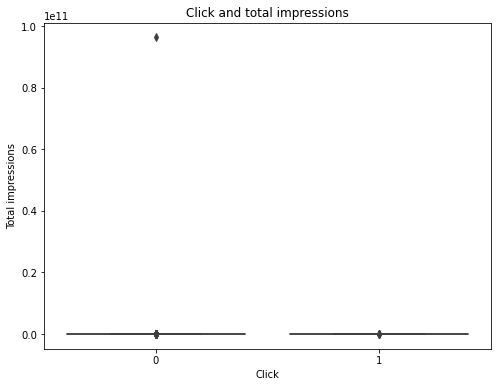

In [10]:
#Visually examine outlier

plt.figure(figsize = (8, 6))
sns.boxplot(x = df['Click'], y = df['Total impressions'])
plt.title("Click and total impressions")
plt.xlabel("Click")
plt.ylabel('Total impressions')

A look at the plot shows that outlier is a single data point which is far fro the remaining data

In [11]:
# View data with 'Total impressions'] > 1000
df[df['Total impressions'] > 1000]

,Addthis,Bebo,Blogcatalog,Blogger,Buddymedia,Cnet,Conduit,Customerlobby,Delicious,Digg,...,Vocus,Wetpaint,Wordpress,Xanga,Yelp,Yfrog,Youtube,Yuku,Click,Total impressions
7864,0,0,0,8,0,0,0,0,0,0,...,0,0,0,1,0,2,20,0,0,96372367695


This shows that user 7864 has over 96 billion impressions. This is unrealistic and most likely a data entry error

In [12]:
# Drop the row with index  = 7864

df = df.drop(df[df['Total impressions'] >500].index)

Text(0, 0.5, 'Total impressions')

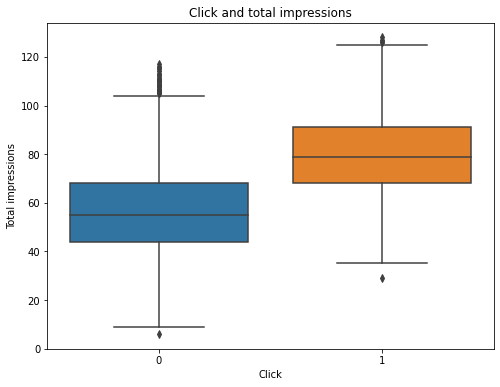

In [13]:
# Further Visual examination of outlier

plt.figure(figsize = (8, 6))
sns.boxplot(x = df['Click'], y = df['Total impressions'])
plt.title("Click and total impressions")
plt.xlabel("Click")
plt.ylabel('Total impressions')

A few outliers are seen outside the interquartile range but this is within a realistic range so wont be discarded. They may play an important part in better understanding the data and having a realistic model.

In [14]:
website_stat=df.describe().T
website_stat

,count,mean,std,min,25%,50%,75%,max
Addthis,9999.0,0.422542,1.014092,0.0,0.0,0.0,0.0,6.0
Bebo,9999.0,0.781378,1.489044,0.0,0.0,0.0,1.0,8.0
Blogcatalog,9999.0,0.568157,1.197755,0.0,0.0,0.0,0.0,7.0
Blogger,9999.0,2.823182,5.571476,0.0,0.0,0.0,0.0,28.0
Buddymedia,9999.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
Yfrog,9999.0,0.380638,0.755277,0.0,0.0,0.0,0.0,4.0
Youtube,9999.0,6.039204,7.891839,0.0,0.0,0.0,12.0,36.0
Yuku,9999.0,0.206621,0.588882,0.0,0.0,0.0,0.0,4.0
Click,9999.0,0.123412,0.328926,0.0,0.0,0.0,0.0,1.0


In [15]:
website_stat[website_stat['max']==0]

,count,mean,std,min,25%,50%,75%,max
Buddymedia,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Having a max and min of 0 means could imply missing data but also literally means that there was no there was no engagement with the ad on this website. For this analysis, We'll not assume missing data. and buddymedia remains a part of the dataset

### Handle Missing Values

In [16]:
### Count all columns with 'Error: value not found' message

data_error=pd.DataFrame(df.isin(['Error: value not found']).any())
data_error.sum()

0    1
dtype: int64

One column has 'Error: value not found' message. The column is found below:

In [17]:
# Find column with Error message
data_error[data_error[0]==True]

,0
Diigo,True


In [18]:
### Replace Error message with numpy's Nan so it can be detected as a missing value and treated appropriately

df['Diigo']=df['Diigo'].replace('Error: value not found', np.nan)

In [19]:
# Check total number of missing values in dataset

df.isnull().sum().sum()

642

In [20]:
# Find columns with missing values

df.columns[df.isnull().any()]

Index(['Diigo'], dtype='object')

'Diigo' has missing values and is an object datatype. This column's data type is changed to float before missing value is handled

In [21]:
# Change datatype of 'Diigo' to float
df['Diigo'] = df['Diigo'].astype(float)

# Handle missing values by filling null cells with the mean of the column to which they belong
df['Diigo'].fillna((df['Diigo'].mean()), inplace=True)

In [22]:
# View sum of null values in training dataset
df.isnull().sum().sum()

0

All missing values have been handled

In [23]:
# View sum of null values in test dataset
df_test.isnull().sum().sum()

0

Test data set has no missing values

In [24]:
# View sum of null values in description dataset
df_desc.isnull().sum().sum()

0

Description data set has no empty values

### Data Consistency

In [25]:
Categories = df_desc['Category'].unique()

In [26]:
print(Categories)

['Social Bookmarking' 'Social Networking' 'Blog' 'Social Media Aggregator'
 'Opinions Site' 'Other' 'User-Generated Content Aggregator' 'Documents'
 'Content / CMS' 'Photo Sharing' 'Social Media Measurement'
 'Video Sharing' 'Micro-Blogging' ' Video Sharing' 'News']


Video Sharing apears twice as 'Video Sharing' and ' Video Sharing'. This will is rectified below.

In [27]:
df_desc['Category'].replace({' Video Sharing':'Video Sharing'}, inplace=True)

In [28]:
Categories = df_desc['Category'].unique()
print(Categories)

['Social Bookmarking' 'Social Networking' 'Blog' 'Social Media Aggregator'
 'Opinions Site' 'Other' 'User-Generated Content Aggregator' 'Documents'
 'Content / CMS' 'Photo Sharing' 'Social Media Measurement'
 'Video Sharing' 'Micro-Blogging' 'News']


This has been resolved

In [29]:
df.dtypes.value_counts()

int64      82
float64     1
dtype: int64

All columns are numerical. This is consistent withe expectation

### Feature Engineering

Engineer new columns that sum up all impressions made in different categories of websites. This will be needed during data exploration

In [30]:
# copy dataframe into new dataframe
df_all= df.copy()

In [31]:
#Engineer new columns that sum up all engagments made in different categories of websites. 

for i in Categories:    
    df_all[i]=0
    name=(df_desc[df_desc['Category']==i]['Name']).array
    df_all[i] = df[name].sum(axis=1)

In [32]:
# Quick check to see if columns have been added

df_all.head()

,Addthis,Bebo,Blogcatalog,Blogger,Buddymedia,Cnet,Conduit,Customerlobby,Delicious,Digg,...,Opinions Site,Other,User-Generated Content Aggregator,Documents,Content / CMS,Photo Sharing,Social Media Measurement,Video Sharing,Micro-Blogging,News
0,0,0,2,0,0,3,6,0,0,0,...,5,15,0,0,0,11,0,0,0,0
1,0,3,0,0,0,0,1,0,0,0,...,2,2,2,0,0,2,0,12,0,4
2,0,2,0,0,0,0,0,0,2,0,...,0,0,2,0,0,6,0,4,0,0
3,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,22,1,0
4,0,0,0,0,0,5,7,0,0,5,...,6,14,5,0,2,13,0,0,2,0


A new dataframe containing all data about categories is extracted for exploratory data analysis. The first includes categories as well as the target variable, 'Click'.

In [33]:
# Create 'data_cat' dataframe 
data_cat= df_all[['Social Bookmarking', 'Social Networking', 'Blog', 'Social Media Aggregator','Opinions Site', 'Other', 'User-Generated Content Aggregator', 'Documents','Content / CMS', 'Photo Sharing', 'Social Media Measurement', 'Video Sharing', 'Micro-Blogging', 'News', 'Click']]

In [34]:
# View 'data_cat' dataframe containing impressions for each user
data_cat

,Social Bookmarking,Social Networking,Blog,Social Media Aggregator,Opinions Site,Other,User-Generated Content Aggregator,Documents,Content / CMS,Photo Sharing,Social Media Measurement,Video Sharing,Micro-Blogging,News,Click
0,1.000000,11,8,5,5,15,0,0,0,11,0,0,0,0,0
1,4.000000,24,13,3,2,2,2,0,0,2,0,12,0,4,0
2,2.000000,6,17,6,0,0,2,0,0,6,0,4,0,0,0
3,0.074917,13,6,1,2,0,0,0,0,0,0,22,1,0,0
4,4.000000,26,4,4,6,14,5,0,2,13,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,23,20,0,1,0,1,0,0,7,0,1,0,1,0
9996,2.000000,21,5,9,3,3,0,0,2,2,0,0,1,3,0
9997,1.000000,24,1,4,1,0,0,5,4,10,0,2,3,0,0
9998,3.000000,21,4,1,3,0,1,0,4,0,0,0,12,0,0


## Part 2: Exploratory Data Analysis

#### 1. Non Click and Click Visualisation

Text(0, 0.5, 'Count')

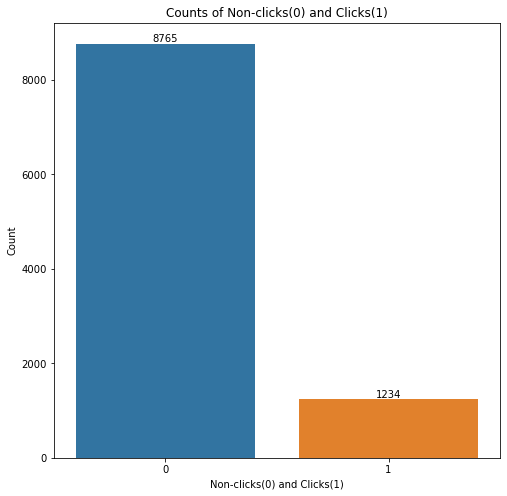

In [35]:
# Visualise clicks and non-clicks

plt.figure(figsize = (8, 8))
click_plot = sns.countplot(x = 'Click', data = data_cat)
for p in click_plot.patches:
    click_plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Counts of Non-clicks(0) and Clicks(1)")
plt.xlabel("Non-clicks(0) and Clicks(1)")
plt.ylabel("Count")

The is a huge data imbalance problem here which will be tackled before modelling.

#### 2. Click through rate

In [36]:
# Calculate click through rate 

Click_through_rate = sum(df['Click'])/sum(df['Total impressions'])
print("Click through rate =",Click_through_rate)

Click through rate = 0.002082570371132942


This means that per 1000 impressions, 2 clicks are gotten. <br>
Assuming: <br>
1. CPM (cost of media) equal to £2.31 per 1000 impressions <br>
2. an average click is worth £1.03 to the client.

The implication is that £2.31 is spent making £2.06 consequently meaning the present marketing strategy is incuring a loss

#### 3. Correlation between Website Categories impressions and Clicks

In [37]:
#Find correlation between Website Categories impressions and Clicks

Category_impressions= data_cat.drop(['Click'], axis=1)
pearson_corr=Category_impressions.corrwith(data_cat['Click'])
pearson_corr.sort_values(ascending=True)

Documents                            0.010453
News                                 0.045374
Video Sharing                        0.057280
Social Media Measurement             0.067935
Content / CMS                        0.071679
Other                                0.074168
Micro-Blogging                       0.076436
Social Media Aggregator              0.091651
Photo Sharing                        0.093335
User-Generated Content Aggregator    0.095882
Social Bookmarking                   0.097822
Social Networking                    0.127179
Opinions Site                        0.270352
Blog                                 0.363993
dtype: float64

<AxesSubplot:title={'center':'Website categories and how their impact on clicks'}, ylabel='correlation'>

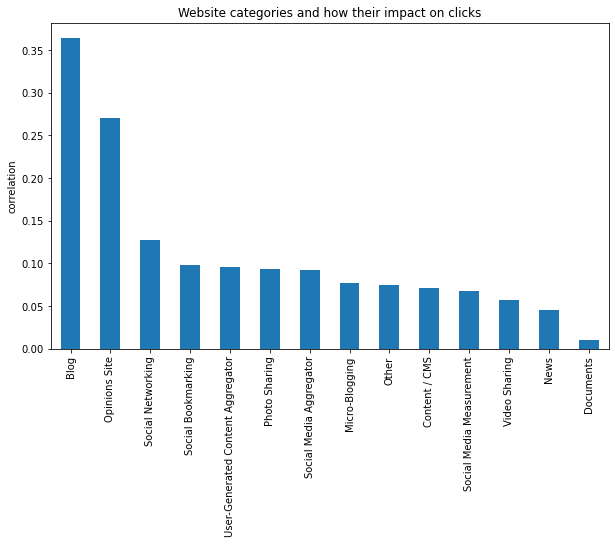

In [38]:
#Plot correlation between Website Categories engagement and Clicks

pearson_corr.sort_values(ascending=False).plot.bar(figsize=(10,6),ylabel= 'correlation', title= 'Website categories and how their impact on clicks')

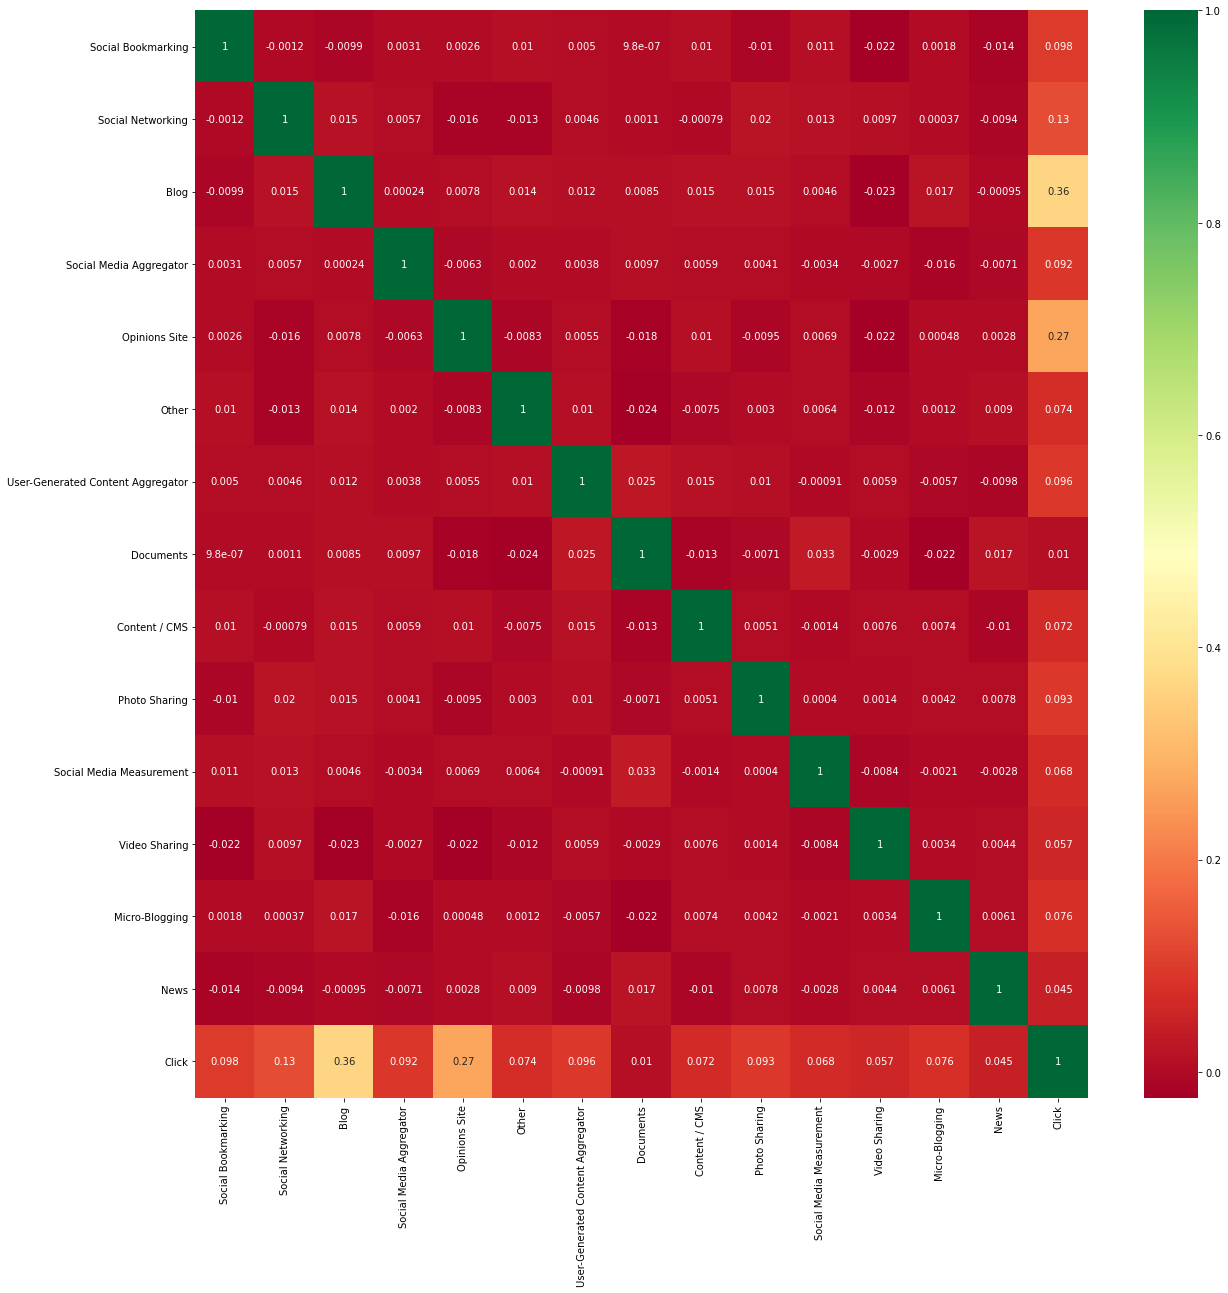

In [39]:
# Show correlation heatmap to check correlation and to see if there are any colinearities between categories.

corrmat=data_cat.corr()
top_corr_features= corrmat.index
plt.figure(figsize=(20,20))

g=sns.heatmap(data_cat[top_corr_features].corr(), annot=True, cmap='RdYlGn')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'Social Networking'),
  Text(1, 0, 'Blog'),
  Text(2, 0, 'Video Sharing'),
  Text(3, 0, 'Photo Sharing'),
  Text(4, 0, 'Other'),
  Text(5, 0, 'Micro-Blogging'),
  Text(6, 0, 'Opinions Site'),
  Text(7, 0, 'Social Media Aggregator'),
  Text(8, 0, 'User-Generated Content Aggregator'),
  Text(9, 0, 'Social Bookmarking'),
  Text(10, 0, 'Content / CMS'),
  Text(11, 0, 'Documents'),
  Text(12, 0, 'News'),
  Text(13, 0, 'Social Media Measurement')])

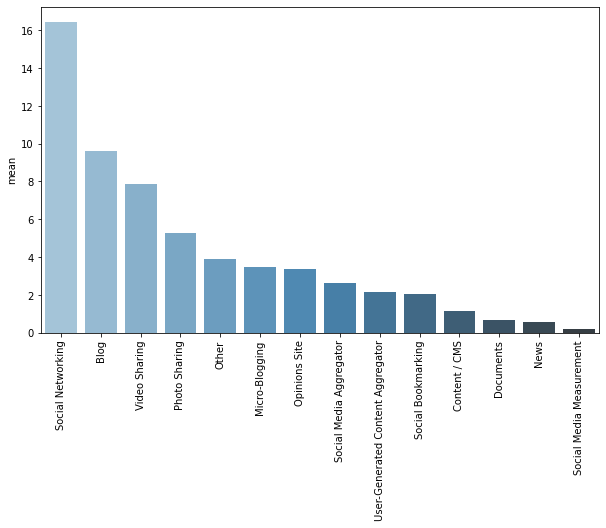

In [40]:
# Plot the present mean impressions on each user for every website category
desc_cat= data_cat.describe().drop(['Click'], axis=1).T.sort_values(by=['mean'],ascending=False)
plt.figure(figsize = (10, 6))
sns.barplot(x=desc_cat.index, y=desc_cat['mean'], data=desc_cat, palette="Blues_d")

plt.xticks(rotation='vertical')

#### 4. Optimum number of impressions

Text(0.5, 1.0, 'Employee Satisfaction Distribution - Turnover V.S. No Turnover')

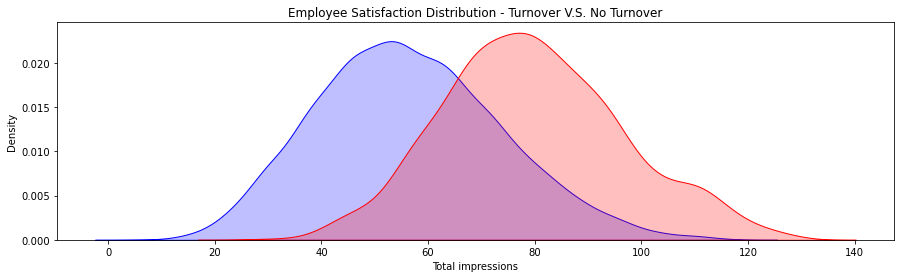

In [41]:
#KDEPlot: Kernel Density Estimate Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df_all.loc[(df['Click'] == 0),'Total impressions'] , color='b',shade=True, label='No click')
ax=sns.kdeplot(df_all.loc[(df['Click'] == 1),'Total impressions'] , color='r',shade=True, label='Click')
plt.title('Employee Satisfaction Distribution - Turnover V.S. No Turnover')

Distribution for both clicks and non-clicks are unimodal and normal. <br>
Generally, more clicks are gotten at a higher engagement. When around 80 impressions are made on customers, They are a lot more likely to click compared to when less or more is made. Having more impressions than this, comes with a cost and may not have any marginal impact. Impressions above 140 are likely to yield no clicks as it shows that customer may be disinterested in what is advert.

#### 5. Best and worst websites to create impressions

In [42]:
#correlation between Website and Clicks
Category_engagement= df.drop(['Click','Total impressions'], axis=1)
pearson_corr=Category_engagement.corrwith(df['Click'])
pearson_corr_top10=pearson_corr.sort_values(ascending=False).iloc[:15]

<AxesSubplot:title={'center':'Fifteen (15) websites that highest impact on clicks'}, ylabel='pearson correlation'>

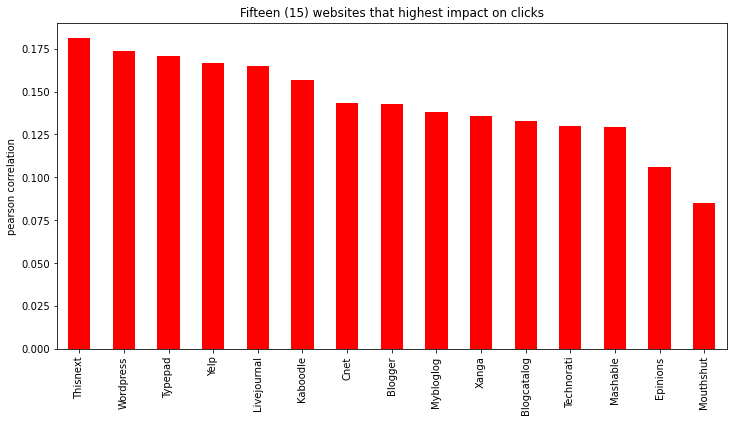

In [43]:
#Plot correlation between Website and Clicks (Top 15)

pearson_corr_top10.sort_values(ascending=False).plot.bar(figsize=(12,6),ylabel= 'pearson correlation', title= 'Fifteen (15) websites that highest impact on clicks', color = 'red')

Paying attention to these sites is boud to have an impact clicks and click through rates 

<AxesSubplot:title={'center':'Fifteen (15) websites that least impact clicks'}, ylabel='Websites'>

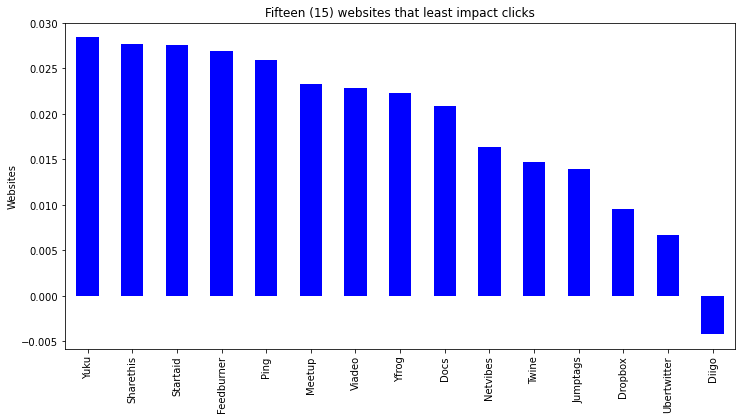

In [44]:
#Plot correlation between Website Categories engagement and Clicks ( Worst 15)
pearson_corr_top10=pearson_corr.sort_values(ascending=True).iloc[:15]
pearson_corr_top10.sort_values(ascending=False).plot.bar(figsize=(12,6),ylabel= 'Websites', title= 'Fifteen (15) websites that least impact clicks', color='blue')

The above sites have least impact on click. Reducing or discontinuing paying for impressions on these websites will help save the marking budget. And use the for more important websites

## Part 3: Modelling

To handle Class imbalance, three balancing techniques are tried out to find best performance.

In [45]:
#Select training data

X= df.drop(['Click','Total impressions'], axis=1)
y= df['Click']

In [46]:
# Create different balanced datasets using different techniques

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE 

# Using random undersampling and a random state of 21
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=21)
X_Under, y_Under= rus.fit_resample(X, y)

# Using random oversampling and a random state of 42
from imblearn.over_sampling import RandomOverSampler 
ros = RandomOverSampler(random_state=42)
X_Over, y_Over = ros.fit_resample(X, y)

# Up sampling using SMOTE (Synthetic Minority Oversampling technique) and a random state of 42
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X, y)

print("Original shape:", X.shape, y.shape)
print("Downsampled shape:", X_Under.shape, y_Under.shape)
print("Upsampled shape:", X_Over.shape, y_Over.shape)
print ("SMOTE sample shape:", X_smote.shape, y_smote.shape)


Original shape: (9999, 81) (9999,)
Downsampled shape: (2468, 81) (2468,)
Upsampled shape: (17530, 81) (17530,)
SMOTE sample shape: (17530, 81) (17530,)


Logistic regression is used because it is easy to comprehend. Cross validation is also used to improve the robustness of the model and reduce possible over fitting

In [47]:
#import logistic regression cross validation 

from sklearn.linear_model import LogisticRegressionCV

In [48]:
# Create modles using original data, undersampled data, oversampled data and oversampled SMOTE data

lr_original = LogisticRegressionCV(cv=5, random_state=0, scoring='accuracy').fit(X, y)
lr_Under = LogisticRegressionCV(cv=5, random_state=0, scoring='accuracy').fit(X_Under, y_Under)
lr_Over = LogisticRegressionCV(cv=5, random_state=0, scoring='accuracy').fit(X_Over, y_Over)
lr_Smote = LogisticRegressionCV(cv=5, random_state=0, scoring='accuracy').fit(X_smote, y_smote)

print("Original model accuracy= {:.2f}%".format(lr_original.score(X,y)*100))
print("Downsampled model accuracy= {:.2f}%".format(lr_Under.score(X,y)*100))
print("Upsampled model accuracy= {:.2f}%".format(lr_Over.score(X,y)*100))
print ("SMOTE sample model accuracy= {:.2f}%".format(lr_Smote.score(X,y)*100))

Original model accuracy= 97.97%
Downsampled model accuracy= 95.93%
Upsampled model accuracy= 96.86%
SMOTE sample model accuracy= 77.38%


Original data performed best so it will be used for the final modelling<br>
It is important to find an optimal cross validation value to have an optimized model

In [49]:
# Train models at different cross validations between 2 and 12
cv_curve={}
for i in range(2,13):
    lr_original = LogisticRegressionCV(cv=i, random_state=0, scoring='accuracy').fit(X, y)
    cv_curve[i]=lr_original.score(X,y)*100

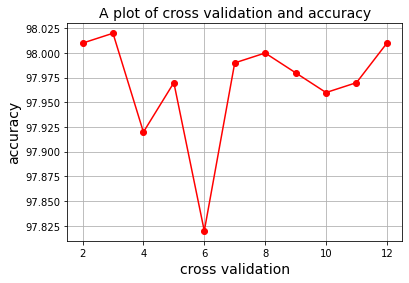

In [50]:
# Plot accuracy against cross validation
cross_validation = list(cv_curve.keys())
accuracy = list(cv_curve.values())
  
plt.plot(cross_validation, accuracy, color='red', marker='o')
plt.title('A plot of cross validation and accuracy', fontsize=14)
plt.xlabel('cross validation', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.grid(True)
plt.show()

The best performing model is gotten using a cross validation of 3

In [51]:
lr_original = LogisticRegressionCV(cv=3, random_state=0, scoring='accuracy').fit(X, y)

## Part 4: Prediction

The original data logistic regression model is used for prediction because it performs better than others.

In [52]:
# Inspect test data
df_test.head()

,Unnamed: 0,Addthis,Bebo,Blogcatalog,Blogger,Buddymedia,Cnet,Conduit,Customerlobby,Delicious,...,Viadeo,Vimeo,Vocus,Wetpaint,Wordpress,Xanga,Yelp,Yfrog,Youtube,Yuku
0,dmp813626769,0,0,0,10,0,0,0,0,1,...,0,1,0,0,0,3,0,1,0,0
1,dmp752138753,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,2,6,0
2,dmp646269971,3,0,3,0,0,0,0,0,1,...,0,0,0,0,0,2,0,2,0,0
3,dmp261229437,0,0,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,2,7,0
4,dmp881635703,0,0,0,0,0,3,0,0,0,...,0,0,0,0,4,2,2,1,13,2


In [53]:
# Further inspection
df_test.shape

(1000, 82)

In [54]:
# Make predictions and join to dataframe

y_predict=lr_original.predict(df_test.drop(['Unnamed: 0'], axis=1))
df_test['Click']=y_predict

In [55]:
# View dataframe

df_test.head()

,Unnamed: 0,Addthis,Bebo,Blogcatalog,Blogger,Buddymedia,Cnet,Conduit,Customerlobby,Delicious,...,Vimeo,Vocus,Wetpaint,Wordpress,Xanga,Yelp,Yfrog,Youtube,Yuku,Click
0,dmp813626769,0,0,0,10,0,0,0,0,1,...,1,0,0,0,3,0,1,0,0,0
1,dmp752138753,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,2,6,0,0
2,dmp646269971,3,0,3,0,0,0,0,0,1,...,0,0,0,0,2,0,2,0,0,0
3,dmp261229437,0,0,0,8,0,0,0,0,0,...,0,0,0,0,0,0,2,7,0,0
4,dmp881635703,0,0,0,0,0,3,0,0,0,...,0,0,0,4,2,2,1,13,2,0


In [56]:
# export as CSV
df_test.to_csv('prediction results.csv', index=False)